In [3]:
# Import dependencies
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
# Define batch and image size 
batch_size = 32
img_height = 160
img_width = 160
data_dir = 'C:/Users/kcfra/Desktop/PLANTS!!/Plant disease classification/plantvillage dataset/color/train'

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  shuffle = True,
  batch_size=batch_size)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  shuffle = True,
  batch_size=batch_size)

Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


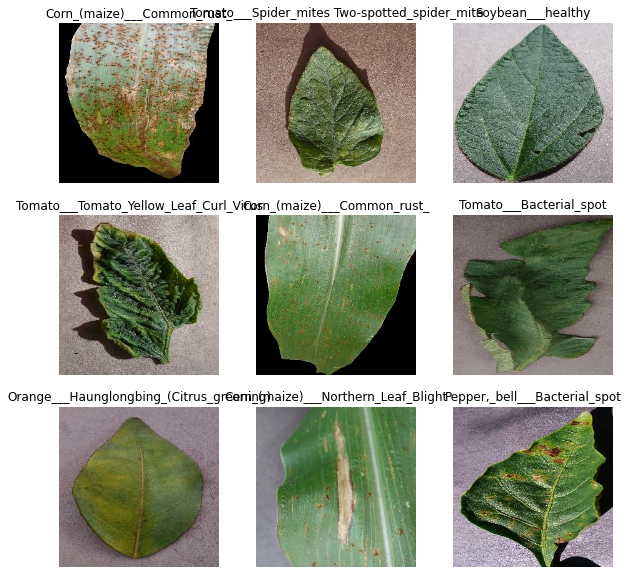

In [9]:
# Visualize some of the images
class_names = train_ds.class_names

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(val_ds))

Number of validation batches: 1358
Number of test batches: 340


In [13]:
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

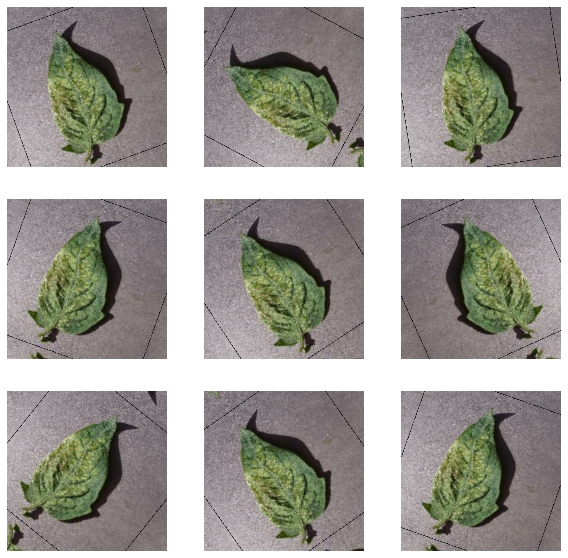

In [16]:
# Repeatedly apply data augmentation to a single image and view the result 
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [18]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (160, 160) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [19]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [20]:
base_model.trainable=False

In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
num_classes = 38
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 38)


In [24]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
len(model.trainable_variables)

2

In [27]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

340/340 [==============================] - 99s 292ms/step - loss: 3.6402 - accuracy: 0.0198


In [28]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.64
initial accuracy: 0.02


In [29]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
1358/1358 [==============================] - 598s 440ms/step - loss: 3.2549 - accuracy: 0.4716 - val_loss: 3.1336 - val_accuracy: 0.6090
Epoch 2/10
1358/1358 [==============================] - 596s 439ms/step - loss: 3.0544 - accuracy: 0.6725 - val_loss: 3.0123 - val_accuracy: 0.7321
Epoch 3/10
1358/1358 [==============================] - 600s 442ms/step - loss: 2.9559 - accuracy: 0.7696 - val_loss: 2.9342 - val_accuracy: 0.8044
Epoch 4/10
1358/1358 [==============================] - 585s 430ms/step - loss: 2.9004 - accuracy: 0.8195 - val_loss: 2.9071 - val_accuracy: 0.8187
Epoch 5/10
1358/1358 [==============================] - 591s 435ms/step - loss: 2.8836 - accuracy: 0.8278 - val_loss: 2.8885 - val_accuracy: 0.8298
Epoch 6/10
1358/1358 [==============================] - 579s 426ms/step - loss: 2.8741 - accuracy: 0.8332 - val_loss: 2.8802 - val_accuracy: 0.8346
Epoch 7/10
1358/1358 [==============================] - 584s 430ms/step - loss: 2.8677 - accuracy: 0.8370 - val_

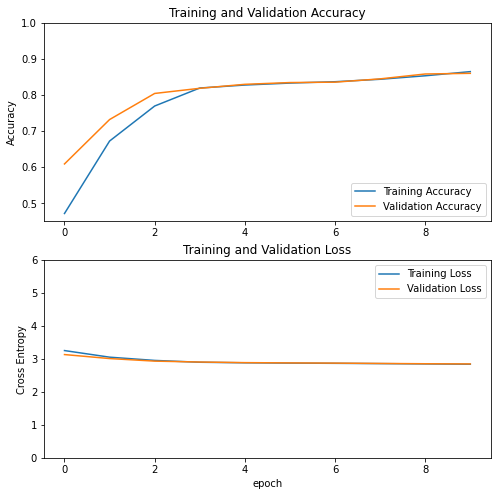

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
base_model.trainable = True

In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [33]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [35]:
len(model.trainable_variables)

58

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
1358/1358 [==============================] - 817s 601ms/step - loss: 2.8188 - accuracy: 0.8697 - val_loss: 2.8126 - val_accuracy: 0.8757
Epoch 11/20
1358/1358 [==============================] - 794s 585ms/step - loss: 2.8034 - accuracy: 0.8821 - val_loss: 2.8072 - val_accuracy: 0.8788
Epoch 12/20
1358/1358 [==============================] - 791s 582ms/step - loss: 2.7977 - accuracy: 0.8870 - val_loss: 2.8029 - val_accuracy: 0.8833
Epoch 13/20
1358/1358 [==============================] - 893s 658ms/step - loss: 2.7929 - accuracy: 0.8912 - val_loss: 2.7925 - val_accuracy: 0.8934
Epoch 14/20
1358/1358 [==============================] - 1346s 991ms/step - loss: 2.7896 - accuracy: 0.8943 - val_loss: 2.7905 - val_accuracy: 0.8940
Epoch 15/20
1358/1358 [==============================] - 814s 599ms/step - loss: 2.7871 - accuracy: 0.8967 - val_loss: 2.7881 - val_accuracy: 0.8966
Epoch 16/20
1358/1358 [==============================] - 832s 613ms/step - loss: 2.7846 - accuracy: 0.898

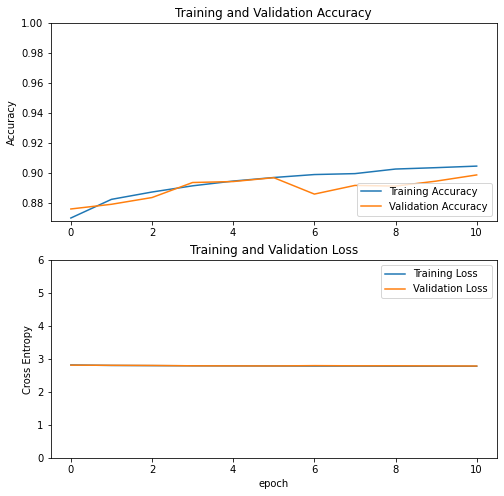

In [37]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [38]:
finer_tune_epochs = 20
total_epochs =  initial_epochs + finer_tune_epochs

history_finer = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=val_ds)

Epoch 20/30
1358/1358 [==============================] - 829s 610ms/step - loss: 2.7785 - accuracy: 0.9044 - val_loss: 2.7849 - val_accuracy: 0.8986
Epoch 21/30
1358/1358 [==============================] - 820s 604ms/step - loss: 2.7780 - accuracy: 0.9049 - val_loss: 2.7796 - val_accuracy: 0.9034
Epoch 22/30
1358/1358 [==============================] - 849s 625ms/step - loss: 2.7763 - accuracy: 0.9064 - val_loss: 2.7827 - val_accuracy: 0.9005
Epoch 23/30
1358/1358 [==============================] - 825s 608ms/step - loss: 2.7757 - accuracy: 0.9071 - val_loss: 2.7816 - val_accuracy: 0.9008
Epoch 24/30
1358/1358 [==============================] - 836s 616ms/step - loss: 2.7756 - accuracy: 0.9070 - val_loss: 2.7878 - val_accuracy: 0.8960
Epoch 25/30
1358/1358 [==============================] - 981s 723ms/step - loss: 2.7745 - accuracy: 0.9082 - val_loss: 2.7871 - val_accuracy: 0.8952
Epoch 26/30
1358/1358 [==============================] - 858s 632ms/step - loss: 2.7738 - accuracy: 0.9087

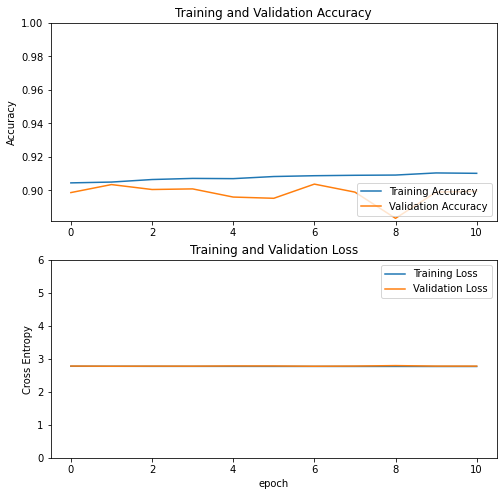

In [39]:
acc = history_finer.history['accuracy']
val_acc = history_finer.history['val_accuracy']

loss = history_finer.history['loss']
val_loss = history_finer.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,6])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()